In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');

In [8]:
def psd2th_wn(freq,psd,dur):
    def psdinteg(freq,psd):
        f = freq; y = psd;
        ndata = len(y);
        a = np.zeros(ndata-1);
        for i in range(ndata-1):
            n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
            if n == -1:
                a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
            else:
                a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
        return np.sqrt(sum(a))
    def log_interp(x,x_spec,y_spec):
        return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec));
    tmax = dur;
    fs = fmax * 20.
    dt = 1 / fs

    spec_grms = psdinteg(freq,psd);

    Nt = int(np.ceil(tmax / dt))
    Nt3 = 3 * Nt
    
    # White Noise
    wn = np.random.normal(0,1,Nt3);
    # num_fft = 2의 n승
    num_fft=2**int(np.ceil(np.log(Nt)/np.log(2)));  
    N = num_fft;
    df = 1. / (N * dt);
    
    m2 = int(num_fft / 2)

    fft_freq = np.linspace(0, (m2 - 1) * df, m2)
    fft_freq2 = np.linspace(0, (num_fft - 1) * df, num_fft)
    
    spec = np.zeros(m2, float)
    sq_spec = np.zeros(m2, float)
    
    js = 0
    
    if(fft_freq[0]<=0):
        fft_freq[0]=0.5*fft_freq[1]        
            
    x=np.log10(fft_freq)    
    xp=np.log10(freq)    
    yp=np.log10(psd)
            
    y=np.interp(x, xp, yp, left=-10, right=-10)

    sq_spec=np.sqrt(10**y)
    
    white_noise_trunc = wn[0:num_fft]
    
    Y = np.zeros(num_fft, complex)

    YF = np.fft.fft(white_noise_trunc)
    
    YFn=YF[0:m2]

    Y[0:m2]=sq_spec*YFn

    Y[0]=0.
    
    for j in range(1, m2):
        Y[num_fft - j] = complex(Y[j].real, -Y[j].imag)
    
    YI = np.fft.ifft(Y)  
    
    YIR = YI.real

    psd_th_m2 = YIR
    
    nL = m2
       
    psd_th = YIR[0:Nt]
    
    Nt = len(psd_th)
    
    TT = np.linspace(0, (Nt - 1) * dt, Nt)
    
    stddev = np.std(psd_th)
    
    psd_th *= (spec_grms / stddev)
    
    return TT,psd_th;

In [3]:
def psdinteg(freq,psd):
    f = freq; y = psd;
    ndata = len(y);
    a = np.zeros(ndata-1);
    for i in range(ndata-1):
        n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
        if n == -1:
            a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
        else:
            a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
    return np.sqrt(sum(a))

In [4]:
# Smooth PSD
def Gs(f,A1,f1,Q1,A2,f2,Q2,fc):
    out1 = np.zeros(len(f)); out2 = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] <= fc:
            out1[i] = A1/np.sqrt(1+((f1-f[i])**2)/(Q1**2));
            out2[i] = A2/np.sqrt(1+((f2-f[i])**2)/(Q2**2));
        else:
            out1[i] = 0;
            out2[i] = 0;
    out = out1 + out2;
    return out

In [5]:
def G3(f):
    A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
    return Gs(f,A1,f1,Q1,A2,f2,Q2,fc);

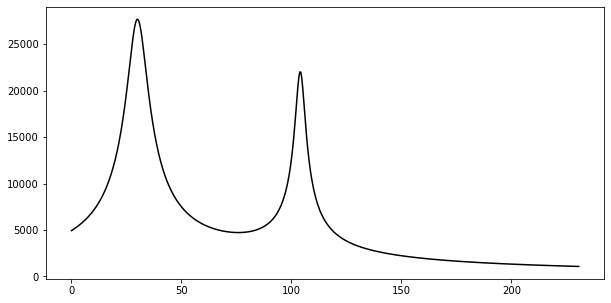

In [6]:
A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = fc; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq3 = np.arange(Nf)*df; psd3 = G3(freq3);
plt.figure(figsize=(10,5));
plt.plot(freq3,psd3,'k-');

spec grms = 1177.62  syn grms = 1177.62


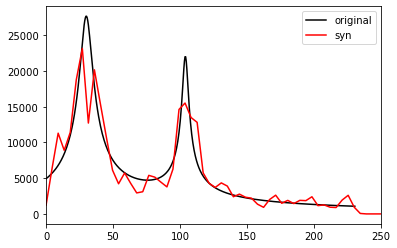

In [16]:
# PSD3
time,th = psd2th_wn(freq3,psd3,1);
# grms 비교
grms_spec = psdinteg(freq3,psd3); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f"%(grms_spec,grms_syn));
# PSD Check
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=2**10);
plt.plot(freq3,psd3,'k-',label='original');
plt.plot(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(0,250);